In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch, os
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
df_2019 = pd.read_csv(f'/data/jmharja/projects/PersonaClassifier/twitter_SU/classification/2019_personality.csv')
df_2020 = pd.read_csv(f'/data/jmharja/projects/PersonaClassifier/twitter_SU/classification/2020_personality.csv')
df_2021 = pd.read_csv(f'/data/jmharja/projects/PersonaClassifier/twitter_SU/classification/2021_personality.csv')
df_2019.shape, df_2020.shape, df_2021.shape

((2799726, 22), (3502171, 22), (2553235, 22))

In [11]:
df_2020

,id,created_at,text,user_id,name,screen_name,description,DrugAbuse,lang,gender,...,tobacco,alcohol,cannabinoids,opioids,stimulants,club_drugs,dissociative_drugs,hallucinogens,other_compounds,prescription_medications
0,1214331878381170694,Mon Jan 06 23:44:15 +0000 2020,nova jut give nose boop first ever boop proud ...,1034618872413020161,geralt hm fuck,lonioiHetairoi,Knell - 🇨🇦 26 - Pan - NB - they/them Nintendo ...,1,en,male,...,0,0,0,0,0,0,0,0,0,0
1,1214331916163305477,Mon Jan 06 23:44:24 +0000 2020,USER drink miche work today,537793543,Ruben,messywuben,NaN,1,en,male,...,0,0,0,0,0,0,0,0,0,0
2,1214331949717839873,Mon Jan 06 23:44:32 +0000 2020,go get drunk sleep,269070737,Le’🖤,__Lucy93,🌻 #fvsugraduate ig: letia93 ♎️☮️ 💫🧘🏾‍♀️ •••• •...,1,en,female,...,0,0,0,0,0,0,0,0,0,0
3,1214332046165913601,Mon Jan 06 23:44:55 +0000 2020,USER bring jacket bcos alcohol keep warm,1060380499292704776,tray🦋,traydominic,the muse | IG: @traydominic | ♊︎,1,en,female,...,0,0,0,0,0,0,0,0,0,0
4,1214332876629643265,Mon Jan 06 23:48:13 +0000 2020,gaspowered mower leaf blower weed whacker coul...,14093707,SFist,SFist,Everything else you need to know about SF & th...,1,en,male,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3502166,1344665680877121539,Thu Dec 31 15:24:15 +0000 2020,USER analogy “ drunk driving car accident kill...,2480289914,Kim,kimerlyus,NaN,1,en,female,...,0,0,0,0,0,0,0,0,0,0
3502167,1344665727035465736,Thu Dec 31 15:24:26 +0000 2020,USER well go bit rough patch whole year actual...,320322773,Christmas Coach,danielsamac,James 1:2-3. Atlanta sports why do you hate me...,1,en,male,...,0,0,0,0,0,1,0,0,0,0
3502168,1344665756378615808,Thu Dec 31 15:24:33 +0000 2020,USER dear you may never cry middle night again...,1116139204369453056,란,ranhmd,walking travesty,1,en,male,...,0,0,0,0,0,0,0,0,0,0
3502169,1344665789958402052,Thu Dec 31 15:24:41 +0000 2020,imiss get high,772098446,Deuce...,Swooshman22,P H E N O M E N A L XC | Instagram: NZST22,1,en,male,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_2019 = df_2019.sample(10000)
df_2020 = df_2020.sample(10000)
df_2021 = df_2021.sample(10000)

In [3]:
fentanyl = ['blonde', 'fenty', 'goodfellas', 'poson', 'blues', 'freddy', 'great bear', 'birria', 'dance fever', 'fuf', 'opes', 'takeover'] + ['apache', 'China Girl', 'China Town', 'Dance Fever', 'Friend', 'Goodfellas', 'Great Bear', 'He-Man', 'Jackpot', 'King Ivory', 'Murder 8', 'Tango and Cash', 'Tango & Cash']
drug_keywords_map= {
'tobacco' : ['nicotine', 'tobacco', 'cigarette', 'cigarrette', 'cigar', 'bidis', 'snuff'],
'alcohol' : ['liquor', 'beer', 'wine'],
'cannabinoids' : ['marijuana', 'blunt', 'dope', 'ganja', 'grass', 'herb', 'joint', 'bud', 'mary jane', 'pot', 'reefer', 'green', 'trees', 'smoke', 'sinsemilla', 'skunk', 'weed','hashish', 'boom', 'gangster', 'hash', 'hash oil', 'hemp'],
'opioids' : ['heroin', 'smack', 'horse', 'brown sugar', 'dope', 
             # 'H',
             'junk', 'skag', 'skunk', 'white horse', 'China white','opium', 'laudanum', 'paregoric', 'big O', 'black stuff', 'block', 'gum', 'hop'],
'stimulants': ['cocaine', 'hydrochloride', 'blow', 'bump',
               # 'C',
                'candy', 'Charlie', 'coke', 'crack', 'flake', 'rock', 'snow', 'toot','amphetamine', 'Biphetamine', 'Dexedrine', 'bennies', 'black beauties', 'crosses', 'hearts', 'LA turnaround', 'speed', 'truck drivers', 'uppers','methamphetamine', 'Desoxyn','meth', 'ice', 'crank', 'chalk', 'crystal', 'fire', 'glass', 'go fast', 'speed'],
'club_drugs':['mdma', 'ecstasy', 'adam', 'clarity', 'eve', "lover's speed", 'peace', 'uppers','flunitrazepam', 'rohypnol', 'forget-me pill', 'mexican valium', 'r2', 'roach', 'roche', 'roffles', 'roofinol', 'rope', 'rophies','ghb', 'Gamma-hydroxybutyrate', 
              # 'G',
              'Georgia home boy', 'grievous bodily harm', 'liquid ecstasy', 'soap', 'scoop', 'goop', 'liquid X'],
'dissociative_drugs':['ketamine', 'Ketalar SV', 'cat Valium',
                      # 'K',
                      'Special K', 'vitamin K','pcp and analogs', 'phencyclidine' 'angel dust', 'boat', 'hog', 'love boat', 'peace pill','salvia divinorum', 'salvia', 'shepherdess’s herb', 'maria pastora', 'magic mint', 'sally-d','dextromethorphan', 'dxm',  'robotripping', 'robo', 'triple'],
'hallucinogens':['lsd','Lysergic acid diethylamide', 'acid', 'blotter', 'cubes', 'microdot', 'yellow sunshine', 'blue heaven', 'mescaline', 'Buttons', 'cactus', 'mesc', 'peyote', 'psilocybin', 'Magic mushrooms', 'purple passion', 'shrooms', 'little smoke'],
'other_compounds':['anabolic_steroids', 'Anadrol', 'Oxandrin', 'Durabolin', 'Depo-Testosterone', 'Equipoise', 'roids', 'juice', 'gym candy', 'pumpers','inhalants', 'Solvents', 'paint thinners', 'gasoline', 'glues', 'gasses', 'butane', 'propane', 'aerosol propellants', 'nitrous oxide',  'nitrites' ,'isoamyl', 'isobutyl', 'cyclohexyl','laughing gas', 'poppers', 'snappers', 'whippets'],
'prescription_medications':['cns_depressants', 'stimulants', 'opioid pain relievers', 'OxyContin','Oxycodone', 'Vicodin', 'Norco', 'Lortab', 'Hydrocodone', 'Acetaminophen', 'Percocet ', 'Oxycodone', 'Acetaminophen','Tramadol','Codeine','Morphine','Methadone','Demerol', 'meperidine','Acetaminophen','Tylenol', 'Excedrin', 'Vanquish','Aspirin', 'Bayer', 'Bufferin', 'Ecotrin', 'Excedrin', 'Vanquish','Diclofenac', 'Voltaren Gel','Ibuprofen', 'Advil', 'Motrin IB','Naproxen', 'Aleve']
}

drug_cols = drug_keywords_map.keys()

In [4]:
# https://nida.nih.gov/sites/default/files/cadchart.pdf
for keyword, words in drug_keywords_map.items():
    pattern = fr'\b(?:{"|".join(words)})\b'
    # print(f'Keyword: {keyword}, Pattern: {pattern}')
    df_2019[keyword] = df_2019['text'].str.contains(pattern, case=False).astype(int)
    df_2020[keyword] = df_2020['text'].str.contains(pattern, case=False).astype(int)
    df_2021[keyword] = df_2021['text'].str.contains(pattern, case=False).astype(int)

In [5]:
df_2019['drug_type'] = df_2019[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)
df_2020['drug_type'] = df_2020[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)
df_2021['drug_type'] = df_2021[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)

In [6]:
years = [2019, 2020, 2021]
age_groups = ['<=18','19-29', '30-39', '>=40']
age_mapping = {
    '<=18': 0,
    '19-29': 1,
    '30-39': 2,
    '>=40': 3
}
gender_mapping = {
    'female': 0,
    'male': 1
}
race_groups = ['api', 'white', 'hispanic', 'black']
drugs_map = {
            'tobacco' :'Tobacco',
            'alcohol' : 'Alcohol',
            'cannabinoids' : 'Cannabinoids',
            'opioids' : 'Opioids',
            'stimulants' : 'Stimulants',
            'club_drugs' : 'Club Drugs',
            'dissociative_drugs': 'Dissociative Drugs',
            'hallucinogens' : 'Hallucinogens',
            'other_compounds' : 'Other Compounds',
            'prescription_medications' : 'Prescription Medications'
}
substances = list(drugs_map.keys())
traits = ['cOPN', 'cCON', 'cEXT', 'cAGR', 'cNEU']

color_2019 = 'lightslategrey'
color_2020 = 'cadetblue'        # Steel Blue
color_2021 = 'steelblue' # Royal Blue
yearly_color = [color_2019, color_2020, color_2021]   # Blue, Green, Red

data= pd.concat([df_2019, df_2020, df_2021], ignore_index=True)
# data= pd.concat( [df_2020], ignore_index=True)
data['created_at'] = pd.to_datetime(data['created_at'], format='%a %b %d %H:%M:%S %z %Y')
data['year'] = data['created_at'].dt.year
data['quarter'] = data['created_at'].dt.to_period('Q')
data['month'] = data['created_at'].dt.to_period('M')
data['week'] = data['created_at'].dt.to_period('W')
data['age_numerical'] = df['age'].map(age_mapping)


/tmp/ipykernel_3353023/3334733651.py:28: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['quarter'] = data['created_at'].dt.to_period('Q')
/tmp/ipykernel_3353023/3334733651.py:29: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['month'] = data['created_at'].dt.to_period('M')
/tmp/ipykernel_3353023/3334733651.py:30: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['week'] = data['created_at'].dt.to_period('W')


<Figure size 1200x600 with 0 Axes>

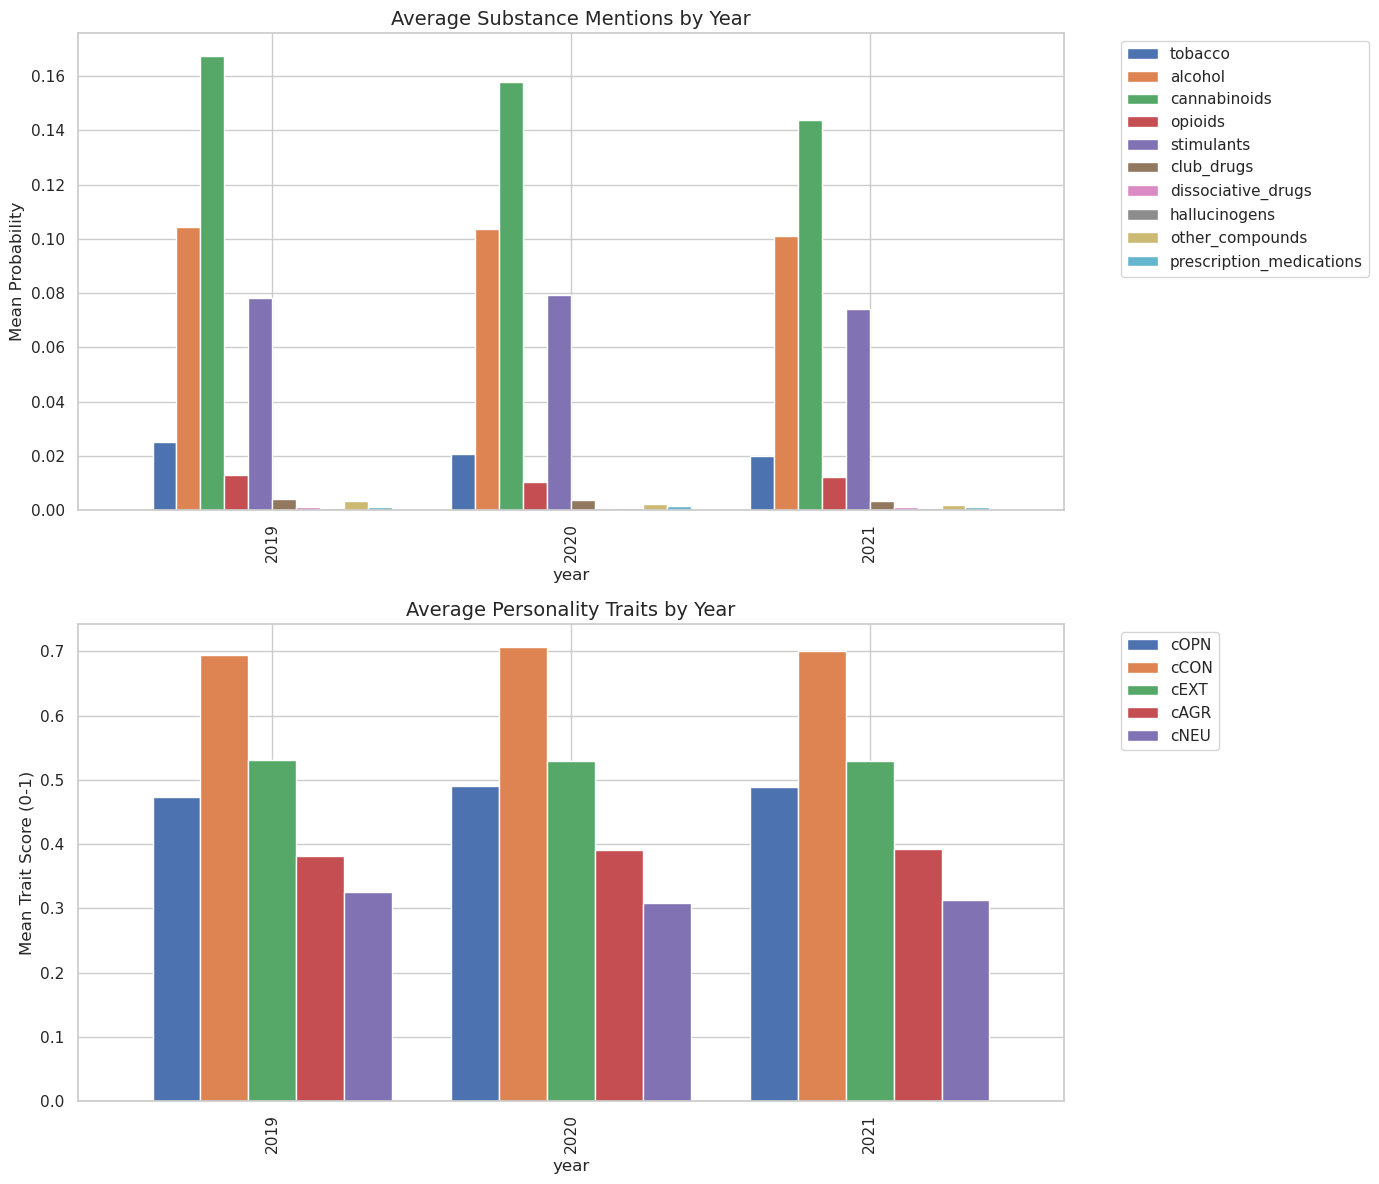

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
# 1. Yearly Trends Analysis ---------------------------------------------------

def plot_yearly_trends(substances, personality_traits):
    """Plot yearly trends for substances and personality traits"""
    # data['year'] = data['created_at'].dt.year
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    
    # Substance mentions by year
    substance_means = data.groupby('year')[substances].mean()
    substance_means.plot(kind='bar', ax=ax1, width=0.8)
    ax1.set_title('Average Substance Mentions by Year', fontsize=14)
    ax1.set_ylabel('Mean Probability')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Personality traits by year
    trait_means = data.groupby('year')[personality_traits].mean()
    trait_means.plot(kind='bar', ax=ax2, width=0.8)
    ax2.set_title('Average Personality Traits by Year', fontsize=14)
    ax2.set_ylabel('Mean Trait Score (0-1)')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    return substance_means, trait_means

# Example usage:
sub_means, trait_means = plot_yearly_trends(list(drugs_map.keys()), traits)

In [8]:
# 4. Statistical Testing for Yearly Differences -------------------------------
from scipy.stats import f_oneway
def test_yearly_differences(variable):
    """Perform ANOVA test for yearly differences"""
    years = sorted(data['year'].unique())
    groups = [data[data['year'] == year][variable] for year in years]
    f_stat, p_value = f_oneway(*groups)
    
    print(f"\nYearly differences in {variable}:")
    print(f"F-statistic: {f_stat:.3f}, p-value: {p_value:.4f}")

    if p_value < 0.05: print("Significant differences found between years")
    else: print("No significant differences between years")
    return f_stat, p_value

for trait in traits:
    test_yearly_differences(trait)


Yearly differences in cOPN:
F-statistic: 10361.865, p-value: 0.0000
Significant differences found between years

Yearly differences in cCON:
F-statistic: 7517.313, p-value: 0.0000
Significant differences found between years

Yearly differences in cEXT:
F-statistic: 153.539, p-value: 0.0000
Significant differences found between years

Yearly differences in cAGR:
F-statistic: 4865.944, p-value: 0.0000
Significant differences found between years

Yearly differences in cNEU:
F-statistic: 9545.652, p-value: 0.0000
Significant differences found between years


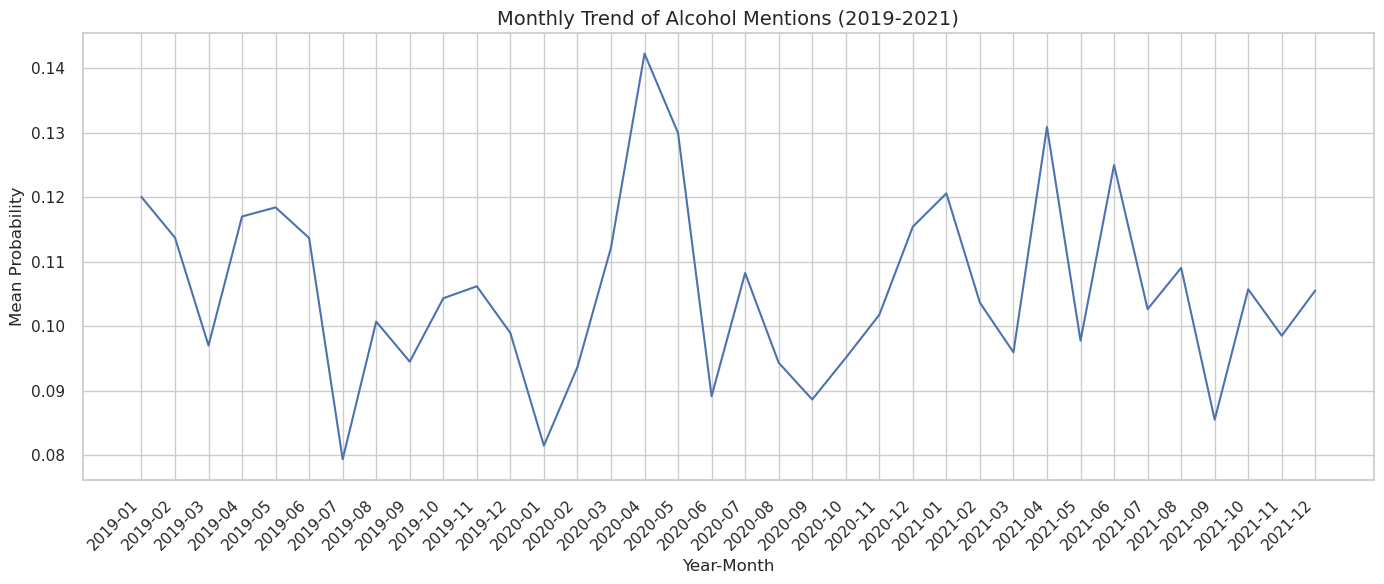

In [ ]:
# # 2. Monthly Trends (2019-2021) -----------------------------------------------
# def plot_monthly_trends(substance):
#     """Plot monthly trends for a specific substance"""
#     monthly_data = data.groupby('month')[substance].mean().reset_index()
#     monthly_data['month'] = monthly_data['month'].astype(str)
#     # Plot
#     plt.figure(figsize=(14, 6))
#     sns.lineplot(data=monthly_data, x='month', y=substance)
#     plt.title(f'Monthly Trend of {substance.capitalize()} Mentions (2019-2021)', fontsize=14)
#     plt.xlabel('Year-Month')
#     plt.ylabel('Mean Probability')
#     plt.xticks(rotation=45, ha='right')
#     plt.tight_layout()
#     plt.show()
#     return monthly_data
# alcohol_monthly = plot_monthly_trends('alcohol')

# from statsmodels.tsa.stattools import grangercausalitytests

# def granger_test(substance, trait, max_lag=2):
#     """Perform Granger causality test"""
#     quarterly = data.groupby(data['created_at'].dt.to_period('Q'))[[substance, trait]].mean()
#     d = quarterly[[substance, trait]].dropna()
    
#     # Test both directions
#     print(f"\nGranger Test: Does {trait} predict {substance}?")
#     res1 = grangercausalitytests(d[[substance, trait]], maxlag=max_lag)
    
#     print(f"\nGranger Test: Does {substance} predict {trait}?")
#     res2 = grangercausalitytests(d[[trait, substance]], maxlag=max_lag)
    
#     return res1, res2

# # Example usage
# granger_test('alcohol', 'cEXT')

In [191]:
# import numpy as np
# from scipy.stats import f_oneway

# def test_substance_trait_relationships(substances, traits, n_bins=3):
    
#     results = {}
    
#     for substance in substances:
#         print(f"\nTesting {substance} across traits:")
#         substance_results = {}
        
#         temp_data = data.copy()
        
#         for trait in traits:
#             temp_data[f'{trait}_bin'] = pd.qcut(temp_data[trait], q=n_bins, labels=False)
            
#             # Get groups
#             bins = sorted(temp_data[f'{trait}_bin'].unique())
#             groups = [temp_data[temp_data[f'{trait}_bin'] == b][substance] for b in bins]
            
#             # Perform ANOVA
#             f_stat, p_value = f_oneway(*groups)
            
#             print(f"\n{substance} vs {trait} (binned into {n_bins} groups):")
#             print(f"F-statistic: {f_stat:.3f}, p-value: {p_value:.4f}")
            
#             if p_value < 0.05:
#                 print("Significant differences found between trait bins")
#             else:
#                 print("No significant differences between trait bins")
            
#             substance_results[trait] = (f_stat, p_value)
        
#         results[substance] = substance_results
    
#     return results

# results = test_substance_trait_relationships(substances, traits, n_bins=3)

In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pointbiserialr, pearsonr

def format_p_value(p, bonferroni_n=1):
    """JMIR-style p-value formatting with Bonferroni correction"""
    adjusted_alpha = 0.05 / bonferroni_n if bonferroni_n > 1 else 0.05
    if p < 0.001:
        return "<.001" + ("*" if p < adjusted_alpha else "")
    p_str = f"={p:.3f}".replace("0.", ".")
    return p_str + ("*" if p < adjusted_alpha else "")

def substance_trait_analysis(data, substances, traits):
    """Comprehensive analysis with substance-trait correlations"""
    # Calculate number of comparisons for Bonferroni
    n_comparisons = len(substances) * len(traits)
    
    # ================== Correlation Matrices ==================
    print("\n\nCORRELATION ANALYSES")
    print("="*60)
    
    # 1. Substance-Trait Correlations (Point-Biserial)
    print("\n\nPOINT-BISERIAL CORRELATIONS: SUBSTANCES × TRAITS")
    print("="*60)
    st_corr = pd.DataFrame(index=substances, columns=traits)
    st_p = pd.DataFrame(index=substances, columns=traits)
    
    for substance in substances:
        for trait in traits:
            r, p = pointbiserialr(data[substance], data[trait])
            st_corr.loc[substance, trait] = f"{r:.2f}"
            st_p.loc[substance, trait] = format_p_value(p, n_comparisons)
    
    print("\nCorrelation Coefficients:")
    print(st_corr)
    print("\nP-values:")
    print(st_p)
    
    # 2. Trait-Trait Correlations (Pearson)
    print("\n\nPEARSON CORRELATIONS AMONG TRAITS")
    print("="*60)
    tt_corr = pd.DataFrame(index=traits, columns=traits)
    tt_p = pd.DataFrame(index=traits, columns=traits)
    
    for t1 in traits:
        for t2 in traits:
            if t1 == t2:
                tt_corr.loc[t1, t2] = "1.00"
                tt_p.loc[t1, t2] = "-"
            else:
                r, p = pearsonr(data[t1], data[t2])
                tt_corr.loc[t1, t2] = f"{r:.2f}"
                tt_p.loc[t1, t2] = format_p_value(p, len(traits)*(len(traits)-1)/2)
    
    print("\nTrait-Trait Correlations:")
    print(tt_corr)
    print("\nP-values:")
    print(tt_p)
    
    # ================== Main Logistic Analysis ==================
    print("\n\nLOGISTIC REGRESSION ANALYSIS")
    print("="*60)
    print(f"\nBinary logistic regression analyses (N = {len(data)}).\n"
          f"Bonferroni correction applied for {n_comparisons} comparisons\n"
          f"(adjusted α = {0.05/n_comparisons:.4f}).\n")
    
    results = []
    for substance in substances:
        print(f"\n{' Analysis for: ' + substance + ' ':-^60}")
        print(f"{'Trait':<20} {'OR [95% CI]':<20} {'p-value':<10} {'r_pb':<8} {'Sig.'}")
        print("-"*60)
        
        for trait in traits:
            # Get correlation first
            r_pb, _ = pointbiserialr(data[substance], data[trait])
            
            # Run regression
            model = smf.glm(f"{substance} ~ {trait}", 
                          data=data, 
                          family=sm.families.Binomial()).fit()
            
            # Format results
            or_ = np.exp(model.params[1])
            ci = np.exp(model.conf_int().loc[trait])
            or_str = f"{or_:.2f} [{ci[0]:.2f}-{ci[1]:.2f}]"
            p_str = format_p_value(model.pvalues[1], n_comparisons)
            sig = "✓" if model.pvalues[1] < (0.05/n_comparisons) else ""
            
            print(f"{trait:<20} {or_str:<20} {p_str:<10} {r_pb:.2f}    {sig}")
            
            results.append({
                'Substance': substance,
                'Trait': trait,
                'OR': or_,
                'CI_low': ci[0],
                'CI_high': ci[1],
                'p_value': model.pvalues[1],
                'pointbiserial_r': r_pb,
                'significant': model.pvalues[1] < (0.05/n_comparisons)
            })
    
    print("\n\nNOTES:")
    print("- OR = Odds Ratio, CI = Confidence Interval")
    print(f"- r_pb = Point-Biserial Correlation Coefficient")
    print(f"- * indicates p < {0.05/n_comparisons:.4f} (Bonferroni-corrected)")
    print("- ✓ indicates significance after correction")
    
    return pd.DataFrame(results)

results_df = substance_trait_analysis(data, substances, traits)



CORRELATION ANALYSES


POINT-BISERIAL CORRELATIONS: SUBSTANCES × TRAITS

Correlation Coefficients:
                           cOPN   cCON   cEXT   cAGR   cNEU
tobacco                   -0.02  -0.01   0.03  -0.03  -0.02
alcohol                    0.04  -0.05   0.05   0.10   0.04
cannabinoids               0.01  -0.02   0.10  -0.04  -0.09
opioids                    0.01   0.01   0.03  -0.01  -0.04
stimulants                 0.01  -0.00   0.02   0.00  -0.03
club_drugs                -0.00  -0.00   0.01   0.01  -0.01
dissociative_drugs         0.00   0.00  -0.00  -0.00  -0.01
hallucinogens             -0.00  -0.00   0.02   0.01  -0.00
other_compounds           -0.00  -0.00   0.03   0.01   0.00
prescription_medications  -0.00   0.00   0.01   0.00  -0.01

P-values:
                            cOPN    cCON    cEXT    cAGR    cNEU
tobacco                   <.001*  <.001*  <.001*  <.001*  <.001*
alcohol                   <.001*  <.001*  <.001*  <.001*  <.001*
cannabinoids              <.001* 

cCON                 0.60 [0.58-0.62]     <.001*     -0.01    ✓
cEXT                 4.60 [4.47-4.75]     <.001*     0.03    ✓
cAGR                 0.21 [0.20-0.22]     <.001*     -0.03    ✓
cNEU                 0.32 [0.31-0.33]     <.001*     -0.02    ✓

------------------ Analysis for: alcohol -------------------
Trait                OR [95% CI]          p-value    r_pb     Sig.
------------------------------------------------------------
cOPN                 2.25 [2.22-2.29]     <.001*     0.04    ✓
cCON                 0.28 [0.27-0.28]     <.001*     -0.05    ✓
cEXT                 3.14 [3.09-3.19]     <.001*     0.05    ✓
cAGR                 12.75 [12.55-12.96]  <.001*     0.10    ✓
cNEU                 2.25 [2.21-2.28]     <.001*     0.04    ✓

---------------- Analysis for: cannabinoids ----------------
Trait                OR [95% CI]          p-value    r_pb     Sig.
------------------------------------------------------------
cOPN                 1.10 [1.08-1.11]     <.001* 

/tmp/ipykernel_3353023/2356326795.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


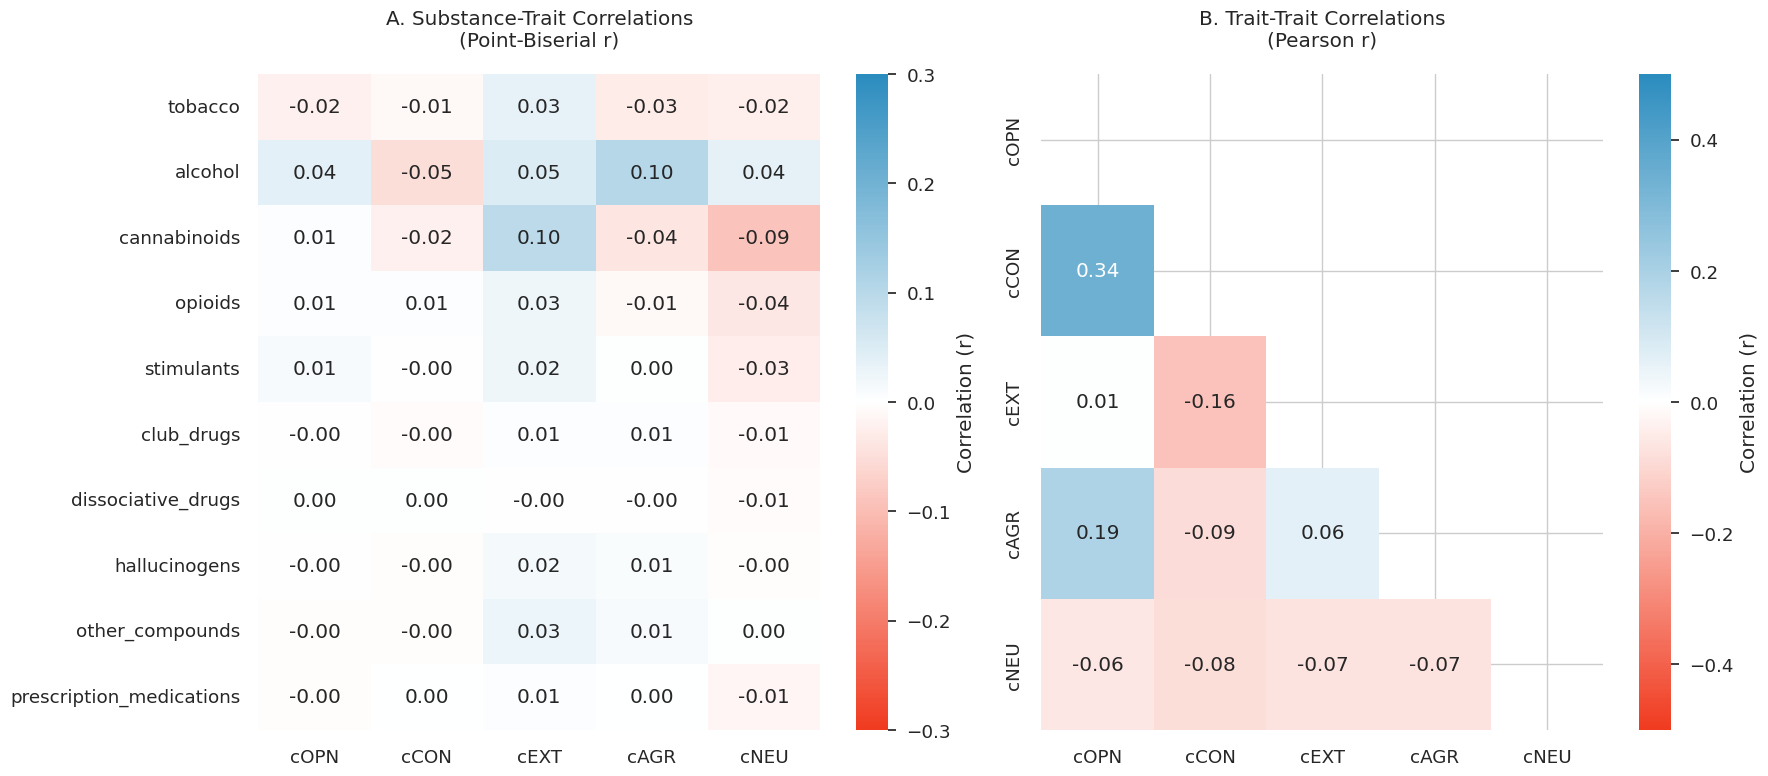

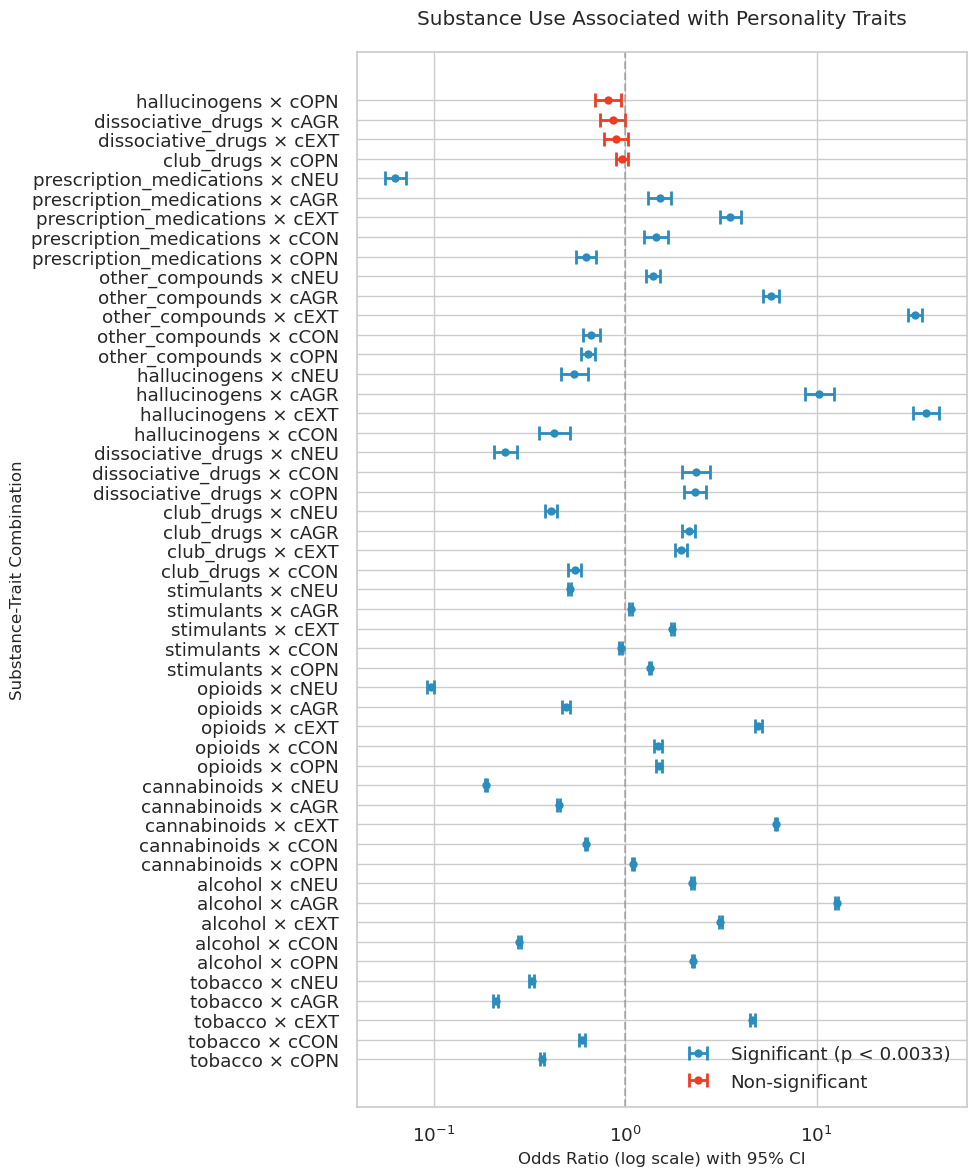

<Figure size 800x550 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pointbiserialr, pearsonr

# Set JMIR-style plotting parameters
plt.style.use('seaborn')
sns.set(style="whitegrid", font_scale=1.2)
colors = ["#2b8cbe", "#f03b20"]  # JMIR blue/red

# ================== 1. Correlation Heatmaps ==================
def plot_correlation_matrices(data, substances, traits):
    """Create publication-ready correlation heatmaps"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # 1. Substance-Trait Point-Biserial Correlations
    st_corr = pd.DataFrame(index=substances, columns=traits)
    for s in substances:
        for t in traits:
            st_corr.loc[s, t], _ = pointbiserialr(data[s], data[t])  # Store numeric values
    
    # Convert to float (this is the critical fix)
    st_corr = st_corr.astype(float)
    
    # Custom diverging colormap
    cmap = LinearSegmentedColormap.from_list('jmir', ["#f03b20", "white", "#2b8cbe"], N=256)
    sns.heatmap(st_corr, annot=True, fmt=".2f", cmap=cmap, 
                center=0, vmin=-0.3, vmax=0.3, 
                ax=ax1, cbar_kws={'label': 'Correlation (r)'})
    ax1.set_title("A. Substance-Trait Correlations\n(Point-Biserial r)", pad=20)
    
    # 2. Trait-Trait Pearson Correlations
    tt_corr = data[traits].corr().astype(float)  # Ensure numeric
    mask = np.triu(np.ones_like(tt_corr, dtype=bool))
    sns.heatmap(tt_corr, annot=True, fmt=".2f", cmap=cmap,
                center=0, vmin=-0.5, vmax=0.5, mask=mask,
                ax=ax2, cbar_kws={'label': 'Correlation (r)'})
    ax2.set_title("B. Trait-Trait Correlations\n(Pearson r)", pad=20)
    
    plt.tight_layout()
    plt.show()

# ================== 2. Logistic Regression Forest Plot ==================
def plot_odds_ratios(results_df):
    """Create forest plot of odds ratios with confidence intervals"""
    plt.figure(figsize=(10, 12))
    
    # Prepare data - ensure numeric types
    plot_data = results_df.copy()
    plot_data['label'] = plot_data['Substance'] + " × " + plot_data['Trait']
    
    # Convert to numeric (critical fix)
    plot_data['OR'] = pd.to_numeric(plot_data['OR'])
    plot_data['CI_low'] = pd.to_numeric(plot_data['CI_low'])
    plot_data['CI_high'] = pd.to_numeric(plot_data['CI_high'])
    
    # Create separate arrays for significant and non-significant results
    sig_data = plot_data[plot_data['significant']]
    non_sig_data = plot_data[~plot_data['significant']]
    
    # Plot significant results in blue
    if not sig_data.empty:
        plt.errorbar(x=sig_data['OR'].values, 
                    y=sig_data['label'].values,
                    xerr=[(sig_data['OR']-sig_data['CI_low']).values, 
                          (sig_data['CI_high']-sig_data['OR']).values],
                    fmt='o', 
                    color=colors[0],
                    capsize=5, capthick=2, elinewidth=2,
                    label='Significant (p < 0.0033)')
    
    # Plot non-significant results in red
    if not non_sig_data.empty:
        plt.errorbar(x=non_sig_data['OR'].values, 
                    y=non_sig_data['label'].values,
                    xerr=[(non_sig_data['OR']-non_sig_data['CI_low']).values, 
                          (non_sig_data['CI_high']-non_sig_data['OR']).values],
                    fmt='o', 
                    color=colors[1],
                    capsize=5, capthick=2, elinewidth=2,
                    label='Non-significant')
    
    # Reference line at OR=1
    plt.axvline(x=1, color='gray', linestyle='--', alpha=0.5)
    
    # Formatting
    plt.xscale('log')
    plt.xlabel("Odds Ratio (log scale) with 95% CI", fontsize=12)
    plt.ylabel("Substance-Trait Combination", fontsize=12)
    plt.title("Substance Use Associated with Personality Traits", pad=20)
    plt.legend(loc='lower right')
    
    plt.tight_layout()
    plt.savefig("odds_ratio_forest_plot.png", dpi=300, bbox_inches='tight')
    plt.show()

# ================== 3. Trait Distribution by Substance Use ==================
def plot_trait_distributions(data, substances, traits):
    """Create violin plots showing trait distributions by substance use"""
    for trait in traits:
        plt.figure(figsize=(12, 6))
        
        # Create subplot for each substance
        for i, substance in enumerate(substances, 1):
            plt.subplot(1, len(substances), i)
            
            # Split data
            users = data[data[substance] == 1][trait]
            non_users = data[data[substance] == 0][trait]
            
            # Violin plot
            sns.violinplot(data=[non_users, users], palette=["#f0f0f0", colors[0]])
            
            # Add statistical annotation
            _, p = stats.mannwhitneyu(users, non_users)
            star = "*" if p < 0.05/len(substances) else "ns"
            plt.text(0.5, 1.05, f"p={p:.3f}{star}", 
                     ha='center', transform=plt.gca().transAxes)
            
            plt.title(f"{substance.capitalize()} Users\nvs Non-users")
            plt.xticks([0, 1], ["Non-users", "Users"])
            plt.ylabel(trait.capitalize() if i == 1 else "")
            plt.ylim(0, 1)
        
        plt.suptitle(f"Trait Distributions by Substance Use: {trait.capitalize()}", y=1.05)
        plt.tight_layout()
        plt.savefig(f"trait_distribution_{trait}.png", dpi=300, bbox_inches='tight')
        plt.show()

# ================== Execute All Visualizations ==================
# 1. Correlation matrices
plot_correlation_matrices(data, substances, traits)

# 2. Forest plot (requires results_df from previous analysis)
plot_odds_ratios(results_df)

# 3. Trait distributions
# plot_trait_distributions(data, substances, traits)

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42  # Ensures text remains editable in PDF
plt.savefig("figure.pdf", format='pdf', bbox_inches='tight')

In [13]:
sub_data = data[data['created_at'].between('2020-01-01', '2020-12-01')]
sub_results_df = substance_trait_analysis(sub_data, substances, traits)



CORRELATION ANALYSES


POINT-BISERIAL CORRELATIONS: SUBSTANCES × TRAITS

Correlation Coefficients:
                           cOPN   cCON   cEXT   cAGR   cNEU
tobacco                   -0.02  -0.00   0.03  -0.03  -0.04
alcohol                    0.04  -0.06   0.04   0.10   0.05
cannabinoids               0.02  -0.01   0.10  -0.03  -0.09
opioids                    0.00  -0.00   0.02  -0.01  -0.03
stimulants                 0.01  -0.00   0.02   0.01  -0.03
club_drugs                -0.00  -0.01   0.01   0.01  -0.01
dissociative_drugs         0.00   0.01   0.00  -0.00  -0.01
hallucinogens             -0.00  -0.01   0.02   0.01  -0.00
other_compounds           -0.00  -0.00   0.02   0.02   0.01
prescription_medications   0.00   0.01  -0.00   0.01  -0.02

P-values:
                            cOPN    cCON    cEXT    cAGR    cNEU
tobacco                   <.001*  <.001*  <.001*  <.001*  <.001*
alcohol                   <.001*  <.001*  <.001*  <.001*  <.001*
cannabinoids              <.001* 

In [18]:
data.columns

Index(['id', 'created_at', 'text', 'user_id', 'name', 'screen_name',
       'description', 'DrugAbuse', 'lang', 'gender', 'age', 'org', 'date',
       'is_teenage', 'drug_type', 'sent_score', 'sentiment', 'cOPN', 'cCON',
       'cEXT', 'cAGR', 'cNEU', 'tobacco', 'alcohol', 'cannabinoids', 'opioids',
       'stimulants', 'club_drugs', 'dissociative_drugs', 'hallucinogens',
       'other_compounds', 'prescription_medications', 'year', 'quarter',
       'month', 'week'],
      dtype='object')

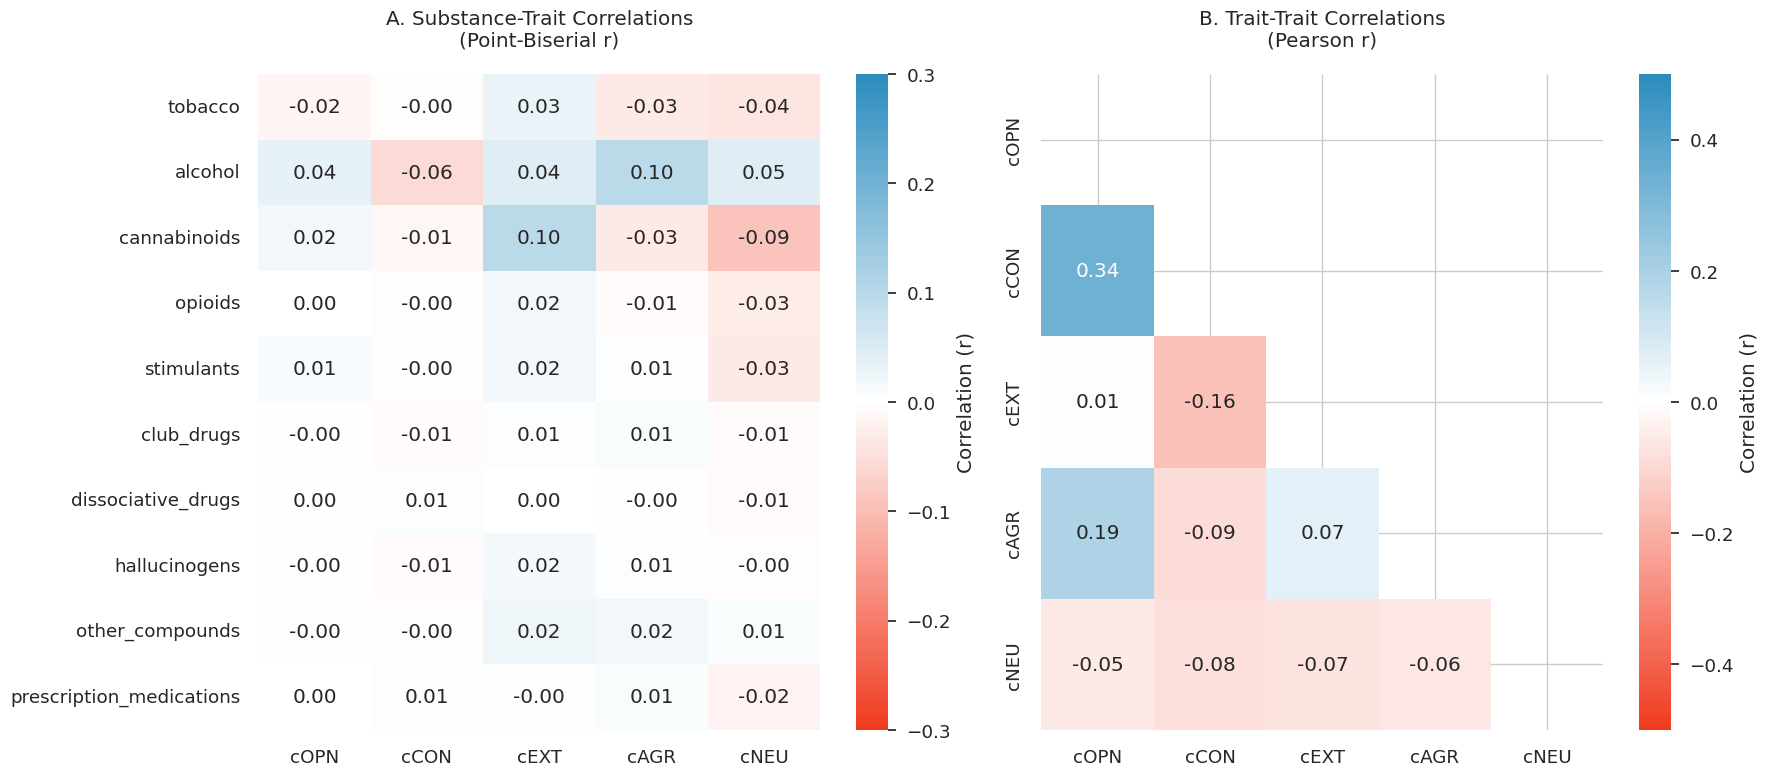

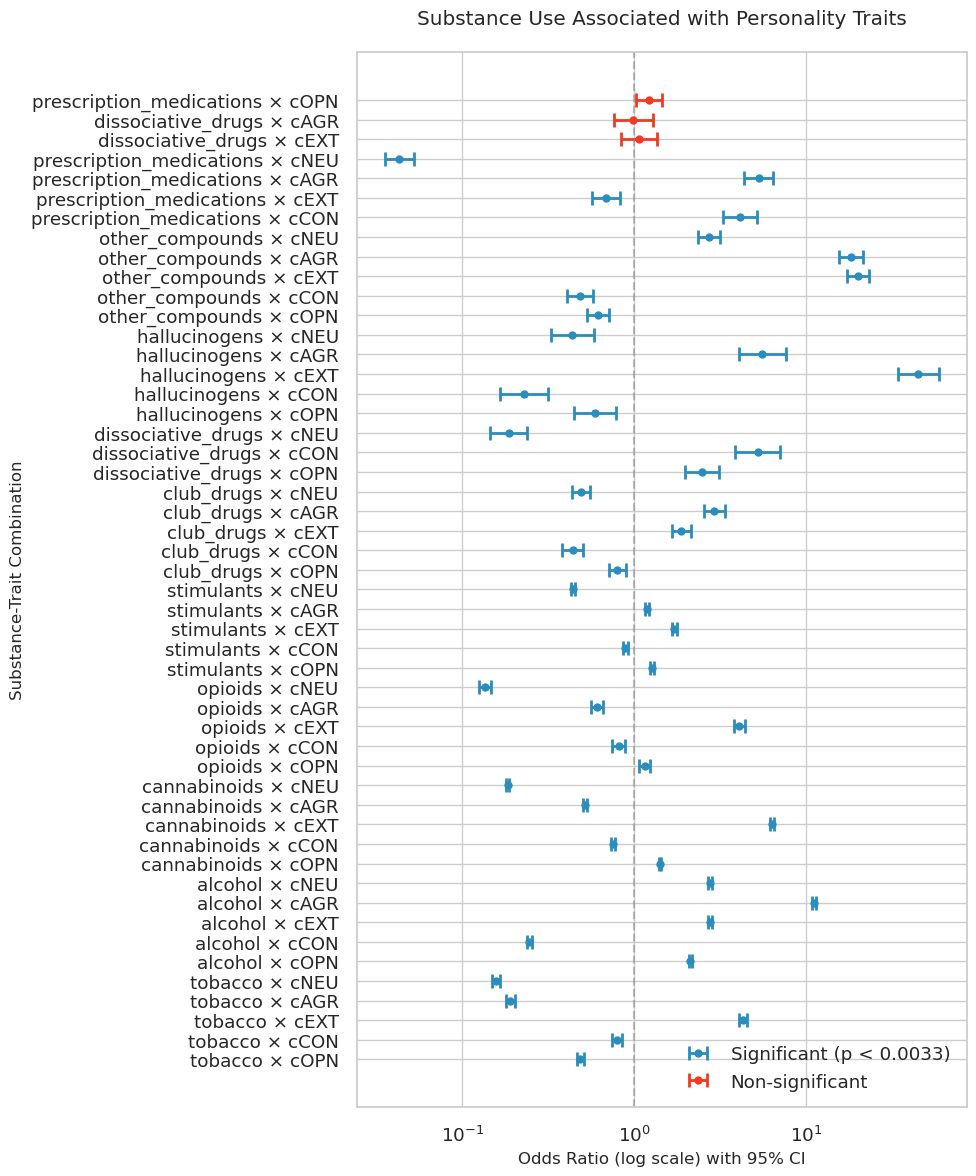

<Figure size 800x550 with 0 Axes>

In [14]:
# ================== Execute All Visualizations ==================
# 1. Correlation matrices
plot_correlation_matrices(sub_data, substances, traits)

# 2. Forest plot (requires results_df from previous analysis)
plot_odds_ratios(sub_results_df)

# 3. Trait distributions
# plot_trait_distributions(data, substances, traits)

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42  # Ensures text remains editable in PDF
plt.savefig("figure.pdf", format='pdf', bbox_inches='tight')

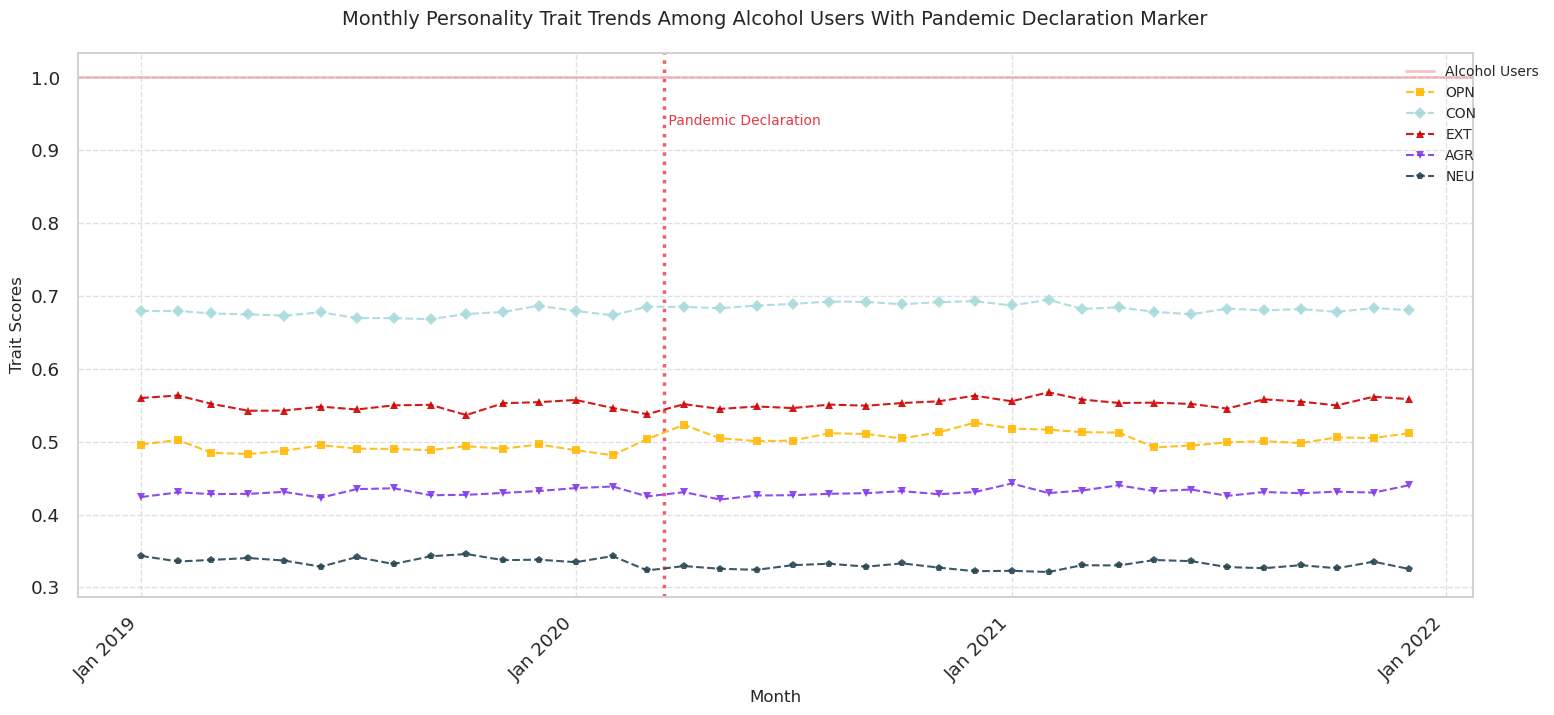

In [15]:
# 3. Personality-Substance Temporal Analysis ----------------------------------
def plot_trait_substance_monthly_trends(traits, pandemic_date='2020-03-15'):
    import matplotlib.dates as mdates
    """Plot monthly relationship between alcohol users and all five traits over time with pandemic marker"""
    
    alcohol_data = data[data['alcohol'] == 1].copy()
    
    # Aggregate data by quarter
    # quarterly_data = data.groupby('quarter').agg({substance: 'mean', **{trait: 'mean' for trait in traits}}).reset_index()
    # quarterly_data['quarter'] = quarterly_data['quarter'].astype(str)

    monthly_data = alcohol_data.groupby('month')[traits].mean().reset_index()
    monthly_data['month'] = monthly_data['month'].astype(str)
    monthly_data['month'] = pd.to_datetime(monthly_data['month'])
    monthly_data = monthly_data.sort_values('month')
    
    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(18, 8))
    
    # Add horizontal line at y=1 to represent alcohol filter threshold
    substance_color = '#e63946'  # Vibrant red
    ax1.axhline(y=1, color=substance_color, linestyle='-', linewidth=2, alpha=0.3, label='Alcohol Users')
    ax1.set_xlabel('Month', fontsize=12)
    ax1.set_ylabel('Trait Scores', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Add pandemic declaration vertical line
    pandemic_date = pd.to_datetime(pandemic_date)
    ax1.axvline(x=pandemic_date, color='#e63946', linestyle=':', linewidth=2.5, alpha=0.8)
    ax1.text(pandemic_date, ax1.get_ylim()[1]*0.95, ' Pandemic Declaration', color='#e63946', fontsize=10, verticalalignment='top')
    
    trait_colors = {
        'cEXT': '#D00000',  # Ferrari red
        'cOPN': '#FFBA08',  # Selective yellow
        'cNEU': '#264653',   # Charcoal 
        'cAGR': '#8338EC',  # Purple
        'cCON': '#a8dadc'  # Light blue
    }
    
    # Plot each trait with different markers and styles
    markers = ['s', 'D', '^', 'v', 'p']
    lines = []
    for i, trait in enumerate(traits):
        line = ax1.plot(monthly_data['month'], monthly_data[trait], color=trait_colors[trait], marker=markers[i], linestyle='--', linewidth=1.5, markersize=6, 
                       alpha=0.9, label=trait[1:])  # Remove 'c' prefix
        lines.extend(line)
    
    # Add alcohol reference line to legend
    alcohol_line = plt.Line2D([], [], color=substance_color, linestyle='-', linewidth=2, alpha=0.3, label='Alcohol Users')
    lines.insert(0, alcohol_line)
    
    # Create legend
    ax1.legend(lines, [l.get_label() for l in lines], loc='upper center', bbox_to_anchor=(1, 1), ncol=1, fontsize=10, framealpha=1)

    # Formatting
    plt.title('Monthly Personality Trait Trends Among Alcohol Users With Pandemic Declaration Marker', fontsize=14, pad=20)
    
    # Improve x-axis date formatting
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    fig.autofmt_xdate(rotation=45)
    
    # Add some padding at the bottom for the legend
    plt.subplots_adjust(bottom=0.2)
    plt.show()
    
    return monthly_data

alcohol_traits_monthly = plot_trait_substance_monthly_trends(traits)

# # 3. Personality-Substance Temporal Analysis ----------------------------------
# def plot_trait_substance_trends(substance, traits):
#     """Plot relationship between substance and all five traits over time"""
    
#     # Aggregate data by quarter
#     quarterly_data = data.groupby('quarter').agg({substance: 'mean', **{trait: 'mean' for trait in traits}}).reset_index()
#     quarterly_data['quarter'] = quarterly_data['quarter'].astype(str)
    
#     # Create figure and primary axis
#     fig, ax1 = plt.subplots(figsize=(16, 8))
    
#     # Plot substance on primary axis (left)
#     substance_color = '#e63946'  # Vibrant red
#     ax1.set_xlabel('Quarter', fontsize=12)
#     ax1.set_ylabel(f'{substance.capitalize()} Probability', color=substance_color, fontsize=12)
#     substance_line = ax1.plot(quarterly_data['quarter'], quarterly_data[substance], 
#                             color=substance_color, marker='o', linestyle='-', 
#                             linewidth=2.5, markersize=8, label=substance.capitalize())
#     ax1.tick_params(axis='y', labelcolor=substance_color)
#     ax1.grid(True, linestyle='--', alpha=0.6)
    
#     # Create secondary axis (right) for traits
#     ax2 = ax1.twinx()
    
#     # Define a color palette for the traits (using ColorBrewer qualitative palette)
#     trait_colors = {
#         'cEXT': '#1d3557',  # Dark blue
#         'cOPN': '#457b9d',  # Medium blue
#         'cNEU': '#a8dadc',  # Light blue
#         'cAGR': '#2a9d8f',  # Teal
#         'cCON': '#f4a261'   # Orange
#     }
    
#     # Plot each trait with different markers and styles
#     markers = ['s', 'D', '^', 'v', 'p']
#     for i, trait in enumerate(traits):
#         trait_line = ax2.plot(quarterly_data['quarter'], quarterly_data[trait], 
#                              color=trait_colors[trait], marker=markers[i], 
#                              lixnestyle='--', linewidth=1.5, markersize=6, 
#                              alpha=0.9, label=trait[1:])  # Remove 'c' prefix
    
#     ax2.set_ylabel('Trait Scores', fontsize=12)
    
#     # Combine legends from both axes
#     lines = substance_line + [line for line in ax2.lines]
#     labels = [l.get_label() for l in lines]
#     ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(lines), fontsize=10, framealpha=1)
    
#     # Formatting
#     plt.title(f'Temporal Trends: {substance.capitalize()} and Personality Traits', fontsize=14, pad=20)
#     fig.tight_layout()
#     plt.xticks(rotation=45)
    
#     # Add some padding at the bottom for the legend
#     plt.subplots_adjust(bottom=0.2)
#     plt.show()
#     return quarterly_data

# alcohol_traits_quarterly = plot_trait_substance_trends('alcohol', traits)

## Core Analytical Approaches

/tmp/ipykernel_3353023/1401094374.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


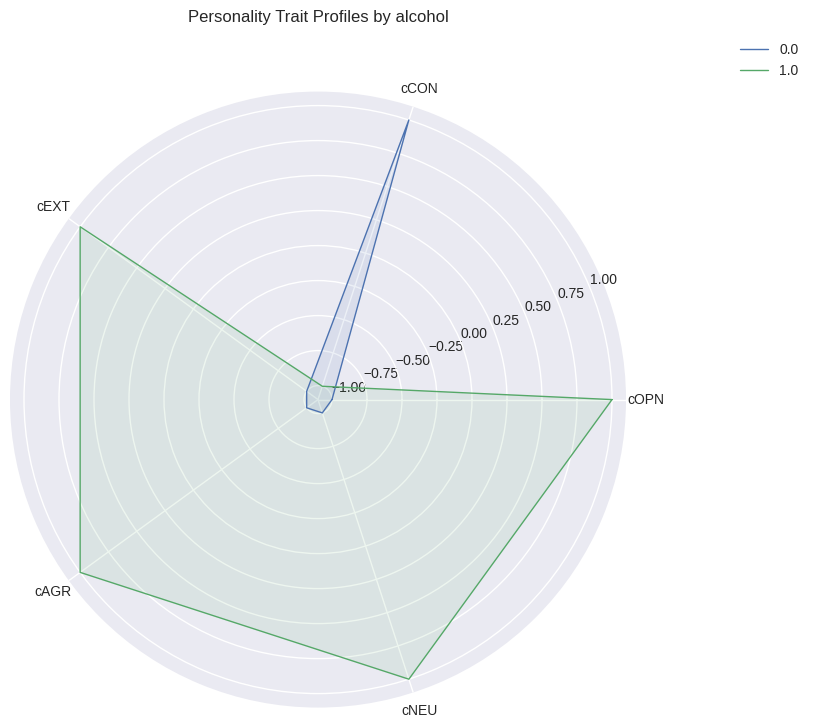

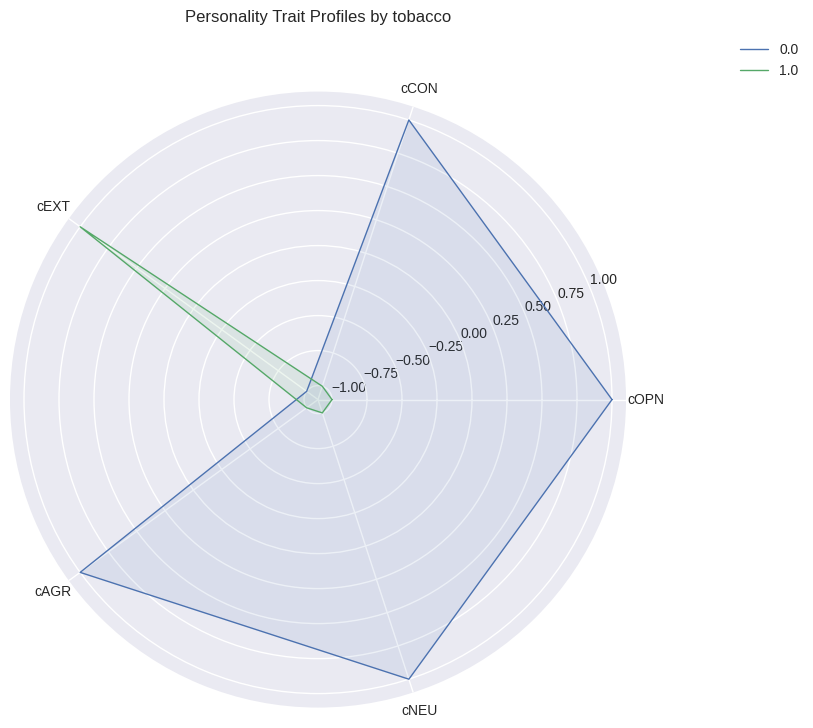

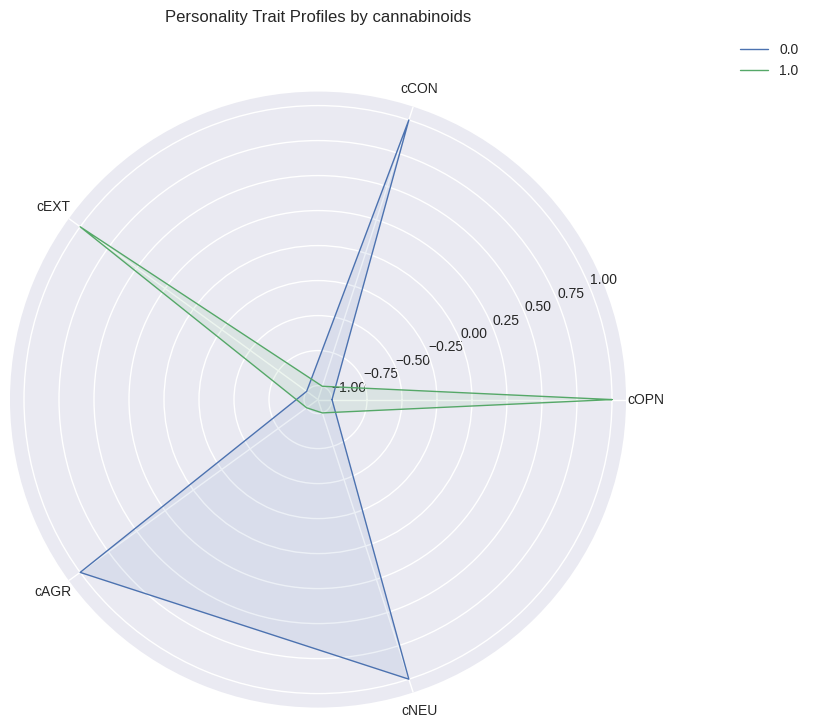

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
import statsmodels.api as sm
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn')

# 1. Radar Chart for Substance Profiles ----------------------------------------
def plot_radar_chart(substance, traits):
    from math import pi
    
    substance_profiles = data.groupby(f'{substance}')[traits].mean().reset_index()
    scaler = StandardScaler()
    substance_profiles[traits] = scaler.fit_transform(substance_profiles[traits])
    
    N = len(traits)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
    for idx, row in substance_profiles.iterrows():
        values = row[traits].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=row[f'{substance}'])
        ax.fill(angles, values, alpha=0.1)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(traits)
    ax.set_title(f'Personality Trait Profiles by {substance}', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

plot_radar_chart('alcohol', traits)
plot_radar_chart('tobacco', traits)
plot_radar_chart('cannabinoids', traits)

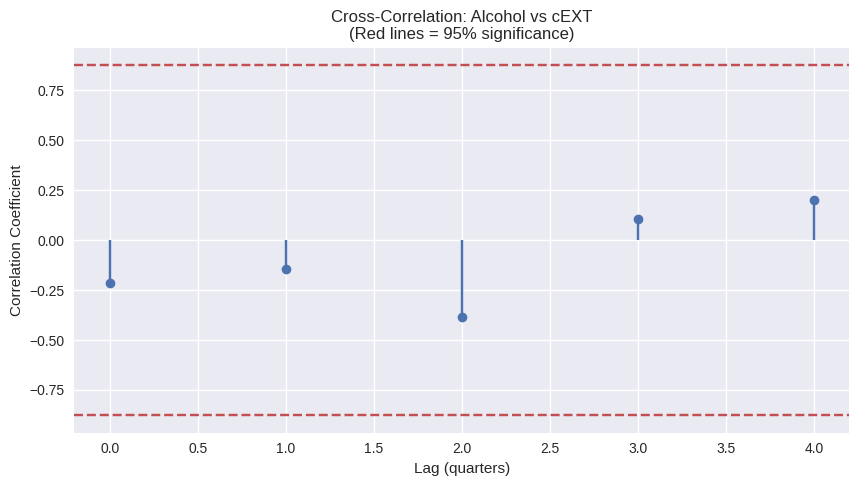


Maximum correlation at lag 2 quarters


array([-0.21387629, -0.14245995, -0.38500946,  0.10532545,  0.19943942])

In [ ]:
from statsmodels.tsa.stattools import ccf
from scipy.stats import pearsonr

def analyze_trait_substance_alignment(substance, trait, max_lag=4):
    """Analyze time-lagged relationships between substance and trait"""
    quarterly = data.groupby('quarter').agg({substance:'mean', trait:'mean'}).reset_index()
    
    # Normalize the series

    substance_series = (quarterly[substance] - quarterly[substance].mean()) / quarterly[substance].std()
    trait_series = (quarterly[trait] - quarterly[trait].mean()) / quarterly[trait].std()
    
    # Cross-correlation analysis
    cross_corr = ccf(substance_series, trait_series, adjusted=False)[:max_lag+1]
    lags = range(0, max_lag+1)
    
    # Find significant correlations (95% confidence)
    critical_value = 1.96 / np.sqrt(len(quarterly))  # For large samples
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.stem(lags, cross_corr, basefmt=" ")
    plt.axhline(y=critical_value, color='r', linestyle='--')
    plt.axhline(y=-critical_value, color='r', linestyle='--')
    plt.title(f'Cross-Correlation: {substance.capitalize()} vs {trait}\n(Red lines = 95% significance)')
    plt.xlabel('Lag (quarters)')
    plt.ylabel('Correlation Coefficient')
    plt.show()
    
    # Print results
    print(f"\nMaximum correlation at lag {np.argmax(np.abs(cross_corr))} quarters")
    for lag, corr in zip(lags, cross_corr):
        if abs(corr) > critical_value:
            print(f"Significant correlation at lag {lag}: r = {corr:.3f}")
    return cross_corr

# Example usage
analyze_trait_substance_alignment('alcohol', 'cEXT')

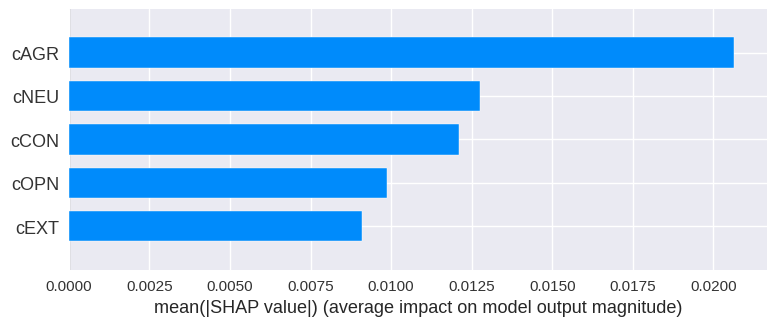

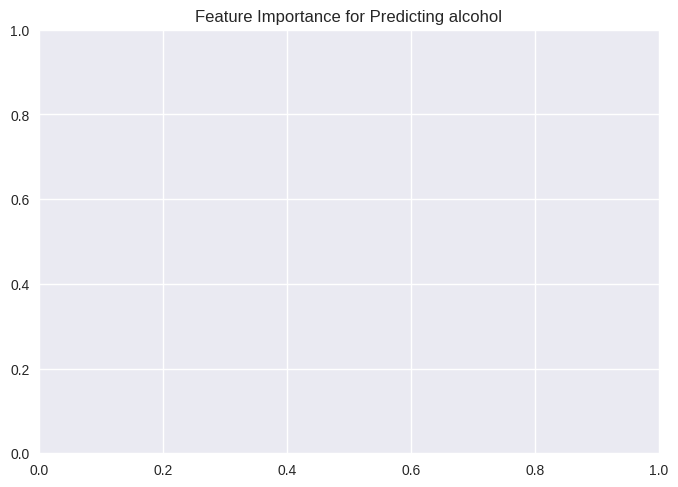


Top predictors for alcohol:
  feature  coefficient  abs_coef
3    cAGR     0.198278  0.198278
1    cCON    -0.123695  0.123695
4    cNEU     0.105825  0.105825
0    cOPN     0.080869  0.080869
2    cEXT     0.079461  0.079461


In [18]:
# 3. Predictive Modeling with SHAP Values ------------------------------------
def analyze_with_shap(substance, traits, demographics=None):
    """Predict substance use from traits using interpretable ML"""
    from sklearn.model_selection import train_test_split
    import shap
    
    if demographics: X = data[traits + demographics]
    else: X = data[traits]
    y = data[substance]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit LASSO model with cross-validation
    model = LassoCV(cv=5, random_state=42)
    model.fit(X_train, y_train)
    
    # SHAP analysis
    explainer = shap.LinearExplainer(model, X_train)
    shap_values = explainer.shap_values(X_test)
    
    # Summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, plot_type='bar')
    plt.title(f'Feature Importance for Predicting {substance}')
    plt.show()
    
    # Return coefficients
    coef_df = pd.DataFrame({
        'feature': X.columns,
        'coefficient': model.coef_,
        'abs_coef': np.abs(model.coef_)
    }).sort_values('abs_coef', ascending=False)

    print(f"\nTop predictors for {substance}:")
    print(coef_df.head(10))
    return model, coef_df

alcohol_model, alcohol_coefs = analyze_with_shap('alcohol', traits, None)

In [ ]:
# 4. MANOVA for Substance Groups ---------------------------------------------
def manova_analysis(substances, traits):
    """Multivariate ANOVA comparing personality across substances"""
    from statsmodels.multivariate.manova import MANOVA
    
    # Filter to primary substance users
    temp_df = data[data['cannabinoids'].isin(substances)].copy()
    
    # Fit MANOVA
    manova = MANOVA.from_formula(
        f"{' + '.join(traits)} ~ alcohol", 
        data=temp_df)
    
    print(manova.mv_test())
    
    # Follow-up univariate ANOVAs
    print("\nUnivariate ANOVA Results:")
    for trait in traits:
        anova = sm.OLS.from_formula(
            f"{trait} ~ alcohol", 
            data=temp_df).fit()
        print(f"\n{trait}:")
        print(anova.anova_table)
    
    return manova

manova_results = manova_analysis(['alcohol', 'cannabinoids', 'opioids'], traits)

ValueError: zero-size array to reduction operation maximum which has no identity

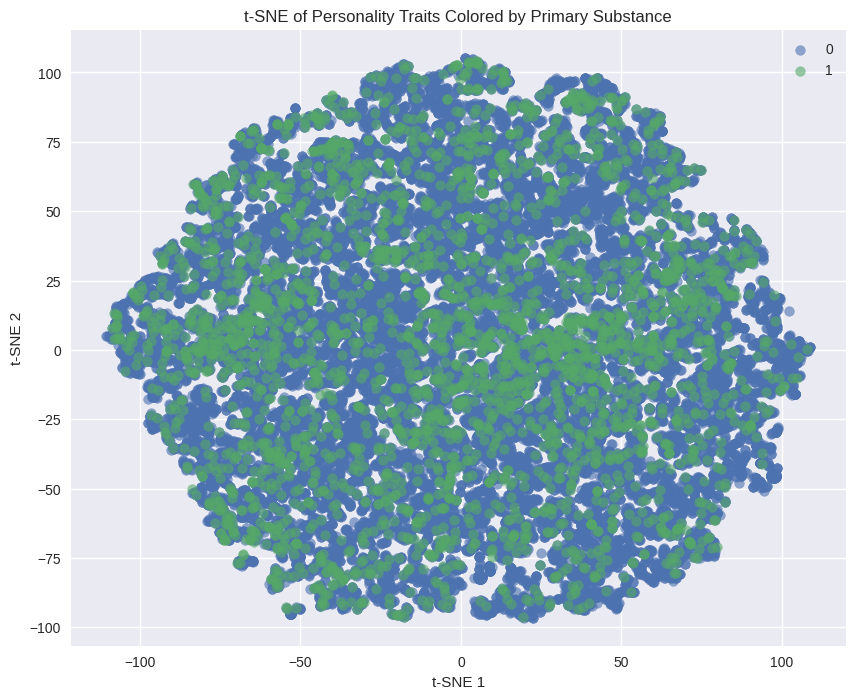

In [ ]:
# 5. t-SNE Visualization -----------------------------------------------------
def plot_substance_tsne(traits, n_components=2, perplexity=30):
    """Visualize substance groups in trait space"""
    from sklearn.manifold import TSNE
    # Prepare data
    X = data[traits].values
    y = data['alcohol'].values
    
    # Run t-SNE
    tsne = TSNE(n_components=n_components,  perplexity=perplexity, random_state=42)
    X_embedded = tsne.fit_transform(X)
    
    # Plot
    plt.figure(figsize=(10, 8))
    for substance in np.unique(y):
        mask = y == substance
        plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], label=substance, alpha=0.6)
    
    plt.title('t-SNE of Personality Traits Colored by Primary Substance')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()
    plt.show()
    return X_embedded
tsne_results = plot_substance_tsne(traits)

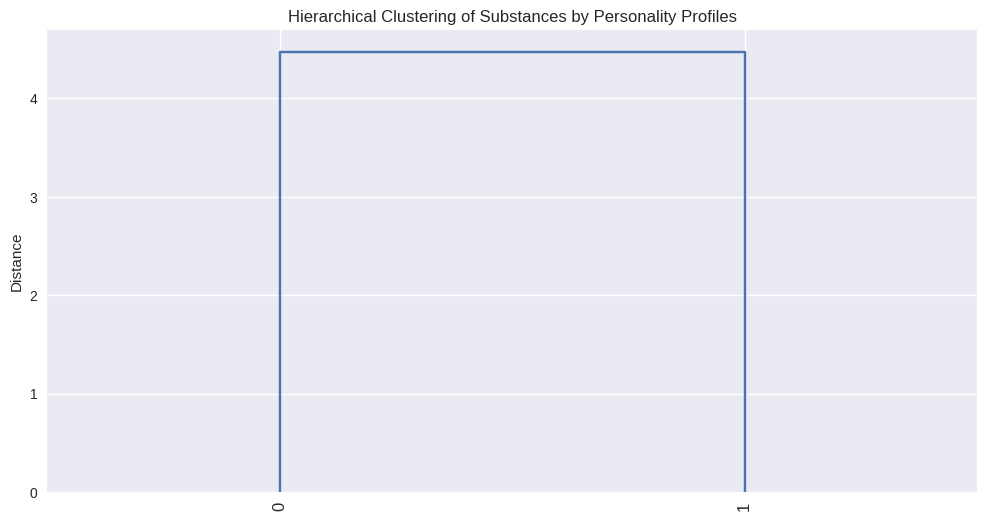

In [ ]:
# 6. Hierarchical Clustering of Substances -----------------------------------
def cluster_substances(traits):
    """Cluster substances based on personality profiles"""
    from scipy.cluster.hierarchy import dendrogram, linkage
    from sklearn.preprocessing import StandardScaler
    
    # Calculate mean traits per substance
    substance_means = data.groupby('alcohol')[traits].mean()
    
    # Standardize and cluster
    scaler = StandardScaler()
    X = scaler.fit_transform(substance_means)
    Z = linkage(X, method='ward')
    
    # Plot dendrogram
    plt.figure(figsize=(12, 6))
    dendrogram(Z, labels=substance_means.index, 
              leaf_rotation=90, color_threshold=2)
    plt.title('Hierarchical Clustering of Substances by Personality Profiles')
    plt.ylabel('Distance')
    plt.show()
    return Z

linkage_matrix = cluster_substances(traits)

In [20]:
from sklearn.mixture import GaussianMixture
import numpy as np

X = data[traits].values 

n_components_range = range(1, 7)
models = [GaussianMixture(n_components=n, random_state=42).fit(X) for n in n_components_range]

n_components=1: AIC=-20096068.7, BIC=-20095807.3, Entropy=1.000
n_components=2: AIC=-20747985.5, BIC=-20747449.7, Entropy=0.811
n_components=3: AIC=-20852275.5, BIC=-20851465.3, Entropy=0.774
n_components=4: AIC=-21026317.7, BIC=-21025233.0, Entropy=0.710
n_components=5: AIC=-21119311.2, BIC=-21117952.0, Entropy=0.679
n_components=6: AIC=-21256705.0, BIC=-21255071.4, Entropy=0.657


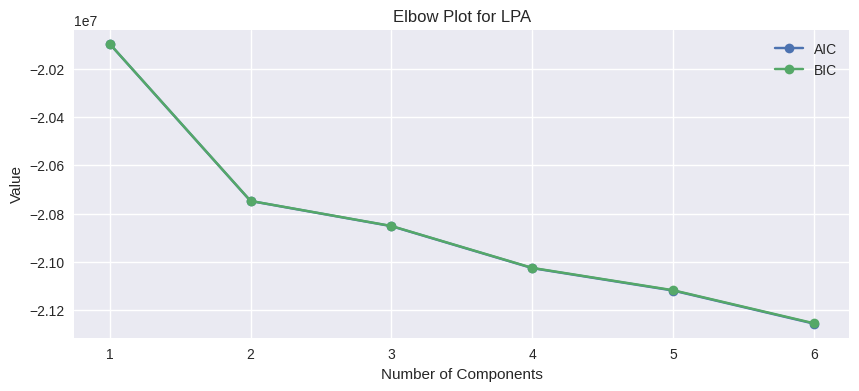

In [21]:
# Compute AIC, BIC, and entropy
aic = [m.aic(X) for m in models]
bic = [m.bic(X) for m in models]
entropy = [np.mean(np.max(m.predict_proba(X), axis=1)) for m in models]

# Print results
for n, aic_val, bic_val, entropy_val in zip(n_components_range, aic, bic, entropy):
    print(f"n_components={n}: AIC={aic_val:.1f}, BIC={bic_val:.1f}, Entropy={entropy_val:.3f}")

plt.figure(figsize=(10, 4))
plt.plot(n_components_range, aic, label='AIC', marker='o')
plt.plot(n_components_range, bic, label='BIC', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Value')
plt.legend()
plt.title('Elbow Plot for LPA')
plt.show()

In [94]:
best_model = GaussianMixture(n_components=2, random_state=42).fit(X)
data['profile'] = best_model.predict(X)

# Check profile means
profile_means = data.groupby('profile')[traits].mean()
print(profile_means)

             cOPN      cCON      cEXT      cAGR      cNEU
profile                                                  
0        0.514575  0.728689  0.493989  0.391747  0.334510
1        0.407770  0.634884  0.612466  0.383004  0.266942


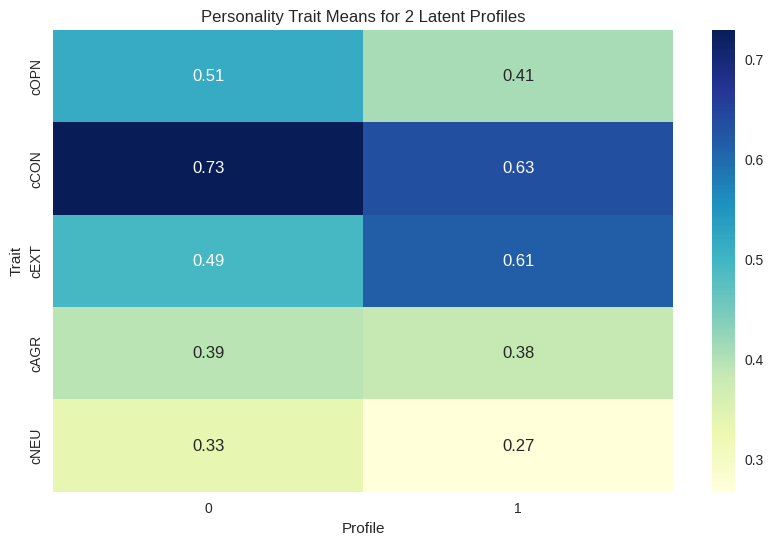

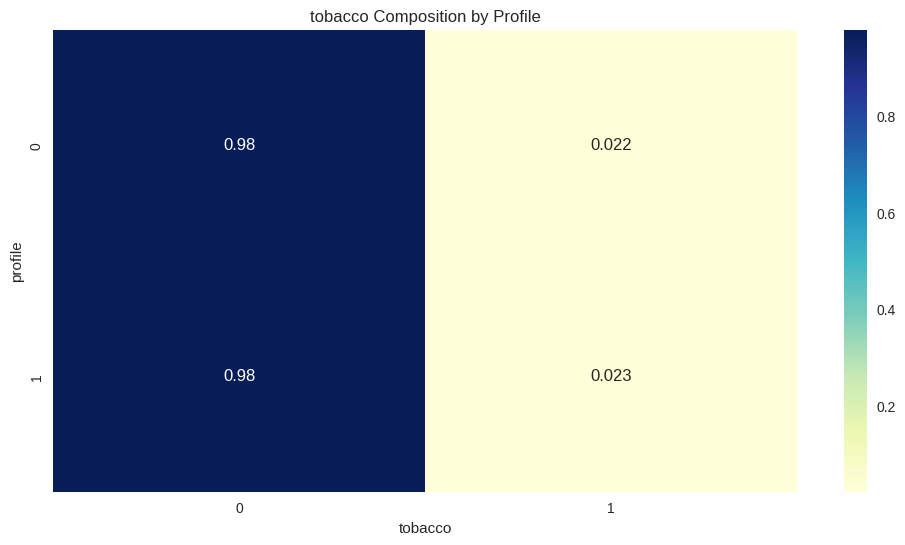

In [95]:
# 7. Latent Profile Analysis -------------------------------------------------
def latent_profile_analysis(traits, n_components=3, substance='alcohol'):
    """Identify latent user profiles"""
    from sklearn.mixture import GaussianMixture
    
    # Prepare data
    X = data[traits].values
    
    # Fit GMM
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    clusters = gmm.fit_predict(X)
    
    # Add clusters to dataframe
    data['profile'] = clusters
    
    # Visualize profiles
    profile_means = data.groupby('profile')[traits].mean()
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(profile_means.T, annot=True, cmap='YlGnBu')
    plt.title(f'Personality Trait Means for {n_components} Latent Profiles')
    plt.ylabel('Trait')
    plt.xlabel('Profile')
    plt.show()
    
    # Analyze 'substance' composition
    cross_tab = pd.crosstab(data['profile'], data[substance], normalize='index')
    plt.figure(figsize=(12, 6))
    sns.heatmap(cross_tab, annot=True, cmap='YlGnBu')
    plt.title(f'{substance} Composition by Profile')
    plt.show()
    
    return gmm, profile_means

gmm_model, profiles = latent_profile_analysis(traits, n_components=2, substance = 'tobacco')

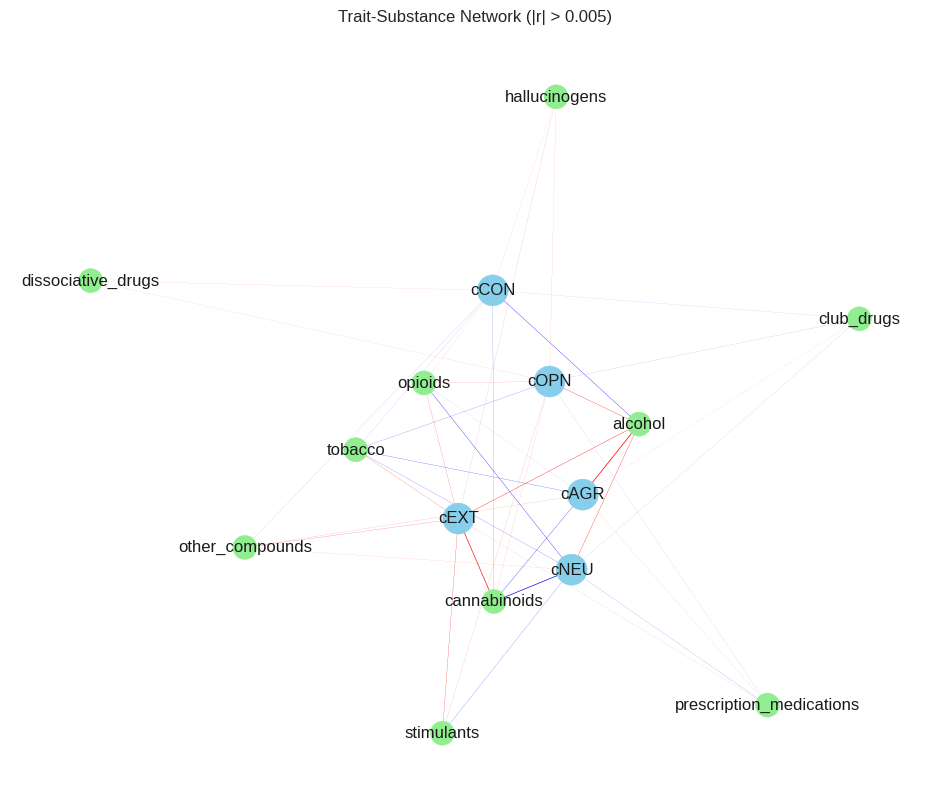

In [78]:
# 8. Trait-Substance Network Analysis ----------------------------------------
def plot_network_graph(traits, substances, corr_threshold=0.005):
    """Create network visualization of trait-substance relationships"""
    import networkx as nx
    
    # Calculate correlations
    corr_matrix = data[traits + substances].corr()
   
    G = nx.Graph()  # Create graph
    for trait in traits: G.add_node(trait, type='trait', size=500)
    for substance in substances: G.add_node(substance, type='substance', size=300)
    
    # Add edges for significant correlations
    for i in range(len(traits)):
        for j in range(len(substances)):
            trait = traits[i]
            substance = substances[j]
            corr = corr_matrix.loc[trait, substance]
            if abs(corr) > corr_threshold:
                G.add_edge(trait, substance, weight=abs(corr)*5, color='red' if corr > 0 else 'blue')
    
    # Draw graph
    pos = nx.spring_layout(G, seed=42)
    
    plt.figure(figsize=(12, 10))
    # Node colors by type
    node_colors = ['skyblue' if G.nodes[n]['type'] == 'trait' else 'lightgreen' for n in G.nodes]

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=[G.nodes[n]['size'] for n in G.nodes], node_color=node_colors)
    nx.draw_networkx_edges(G, pos, width=[d['weight'] for u,v,d in G.edges(data=True)], edge_color=[d['color'] for u,v,d in G.edges(data=True)])
    nx.draw_networkx_labels(G, pos)

    plt.title(f'Trait-Substance Network (|r| > {corr_threshold})')
    plt.axis('off')
    plt.show()
    return G

network_graph = plot_network_graph( traits, ['tobacco', 'alcohol', 'cannabinoids', 'opioids', 'stimulants', 'club_drugs', 'dissociative_drugs', 'hallucinogens', 'other_compounds', 'prescription_medications'], corr_threshold=0.005)